In [1]:
import m2aia as m2
import numpy as np
import tensorflow as tf
from msiPL.Computational_Model import VAE_BN
import seaborn as sns
#import seaborn_image as seaim

import matplotlib.pyplot as plt
import os

from Example_IV_Helpers import running_variance_update as update 
from Example_IV_Helpers import running_variance_finalize as finalize
from Example_IV_Helpers import BatchSequence

from msiPL.LearnPeaks import *

from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(19,6)})

2022-11-09 15:34:53.595770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:34:53.743780: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 15:34:53.775899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 15:34:54.411904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
from pathlib import Path

latent_dim = 5
interim_dim = 256
epochs = 50
batch_size = 128

models = []
handles = []

Path("models").mkdir(parents=True, exist_ok=True)

# READ DATA
for f in file_names:

    I = m2.ImzMLReader(f)
    I.Execute()
    handles.append(I)

    vae = VAE_BN(I.GetXAxisDepth(), interim_dim, latent_dim)
    myModel, encoder = vae.get_architecture()

    if os.path.exists(f'models/{interim_dim}_{f}.h5'):
        # ============= Load Model =================
        myModel.load_weights(f'models/{interim_dim}_{f}.h5')
    else:
        # ============= Model Training =================
        dataset = m2.Dataset.SpectrumDataset([I])
        gen = BatchSequence(dataset, batch_size=batch_size, shuffle=True)
        history = myModel.fit(gen, epochs=epochs)
        myModel.save_weights(f'models/{interim_dim}_{f}.h5')
    
    models.append([myModel, encoder])

[Wed Nov  9 15:34:56 2022 
19.469] [imzML]: 150429_ew_section1_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 206x107
	[image dims]: 5150.000000x2675.000000


2022-11-09 15:34:56.664312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:34:58.962657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47207 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2022-11-09 15:34:58.964520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47207 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2022-11-09 15:34:58.965667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/tas

[26.640] [imzML]: 150429_ew_section2_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 220x171
	[image dims]: 5500.000000x4275.000000
[39.435] [imzML]: 150505_ew_section3_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 224x169
	[image dims]: 5600.000000x4225.000000
[53.840] [imzML]: 150417_ew_section4_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 197x192
	[image dims]: 4925.000000x4800.000000


In [3]:
learned_peaks = []
Beta = 1.3
for k, I in enumerate(handles):   
    I : m2.ImzMLReader = I

    count = 0
    mean = np.zeros_like(I.GetXAxis())
    deltaM2  = np.zeros_like(I.GetXAxis())
    existingAggregate = (count, mean, deltaM2)

    for i in range(I.GetNumberOfSpectra()):
        xs, ys = I.GetSpectrum(i)
        existingAggregate = update(existingAggregate, ys)

    _, var, _ = finalize(existingAggregate)
    W_enc = models[k][1].get_weights()
    _, _, _, Real_PeakIdx = LearnPeaks(I.GetXAxis(), W_enc, np.sqrt(var), latent_dim,Beta, I.GetMeanSpectrum())
    learned_peaks.append(Real_PeakIdx)


In [4]:
mean_orig_spectra = []
mean_recon_spectra = []
for i, (M, I) in enumerate(zip(models,handles)):
    dataset = m2.Dataset.SpectrumDataset([I])
    gen = m2.BatchGenerator(dataset, batch_size=I.GetNumberOfSpectra(), shuffle=True)
    X = gen[0]
    R = M[0].predict(X)
    mean_orig_spectra.append(np.mean(X,axis=0))
    mean_recon_spectra.append(np.mean(R,axis=0))

880/880 [==============================] - 3s 4ms/step


In [5]:
# mean_recon_B = np.load("IV_B.np.npy")
# learned_peaks_B = np.load("learned_peaks.npy")
# print(mean_recon_B.shape)
# print(learned_peaks_B.shape)

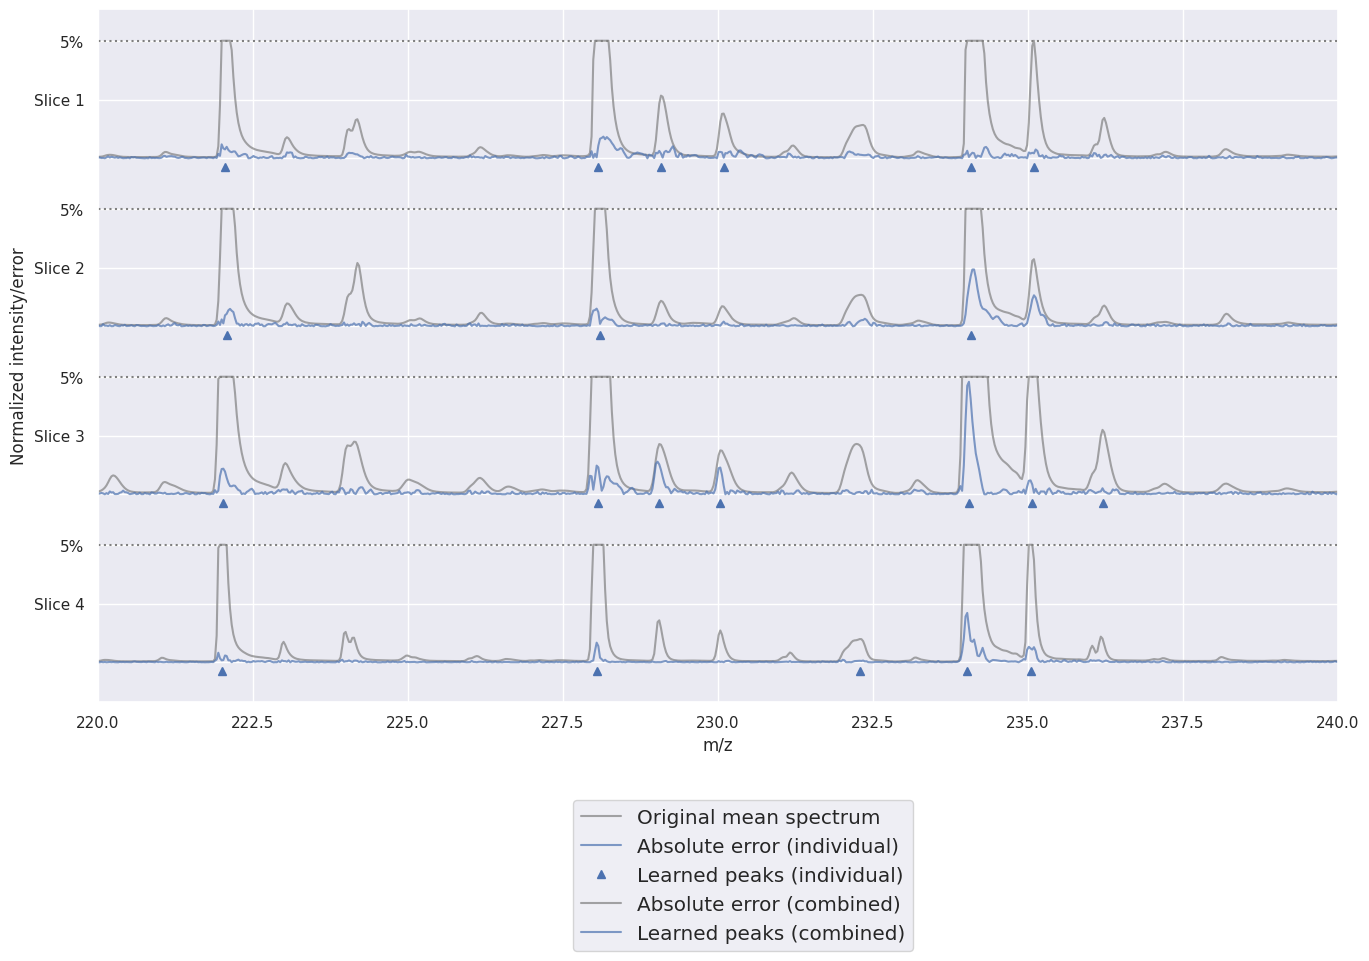

In [6]:
xs = I.GetXAxis()
colors = ['r{}','g{}','b{}','y{}']
labels = []
ytick = []
yhlines = []
ytick_label = []
scale_factor = 0.7
fraction_of_max = 0.05
stretch_factor = 1
plt.figure(figsize=(16,9))
for i, _ in enumerate(handles):
    ytick.append(-i*stretch_factor)
    yhlines.append(-i*stretch_factor-0.15)
    ytick.append(((-i*stretch_factor)+(-i*stretch_factor+scale_factor))*0.5)
    ytick.append(-i*stretch_factor+scale_factor)
    ytick_label.append('')
    ytick_label.append(f'Slice {i+1}')
    ytick_label.append(f'{int(fraction_of_max*100)}%')
    err1 = np.abs(mean_orig_spectra[i]-mean_recon_spectra[i])
    # err2 = np.abs(mean_orig_spectra[i]-mean_recon_B[i])
    plt.plot(xs, np.clip(mean_orig_spectra[i]/(np.max(mean_orig_spectra[i])*fraction_of_max),0,1)*0.7 - (i*stretch_factor),  color='grey', alpha=0.7)
    # plt.plot(xs, np.clip(mean_recon_spectra[i]/(np.max(mean_orig_spectra[i])*fraction_of_max),0,1)*0.7 - (i*stretch_factor), color='#facd60', alpha=0.7)
    # plt.plot(xs, np.clip(mean_recon_B[i]/(np.max(mean_orig_spectra[i])*fraction_of_max),0,1)*0.7 - (i*stretch_factor), color='b', alpha=0.7)
    plt.plot(xs, err1/(np.max(mean_orig_spectra)*fraction_of_max) - (i*stretch_factor), color='b', alpha=0.7)
    plt.plot(xs[learned_peaks[i]], [-(i*stretch_factor)-0.05 for _ in learned_peaks[i]], '^', color='b')

    # plt.plot(xs, err2/(np.max(mean_orig_spectra)*fraction_of_max) - (i*stretch_factor), color='orange', alpha=0.7)
    # plt.plot(xs[learned_peaks_B[0]], [-(i*stretch_factor)-0.12 for _ in learned_peaks_B[0]], '^', color='orange')

labels.append(f'Original mean spectrum')
# labels.append(f'Reconstructed mean spectrum (individual)')
# labels.append(f'Reconstructed mean spectrum (combined)')
labels.append(f'Absolute error (individual)')
labels.append(f'Learned peaks (individual)')
labels.append(f'Absolute error (combined)')
labels.append(f'Learned peaks (combined)')
plt.hlines(ytick[2::3],200,270, colors='gray', label=[f'Section {l+1}' for l in range(4)], linestyles='dotted')
plt.legend(labels=labels, fontsize='large', bbox_to_anchor=(0.375,-0.25), loc="center left")
plt.xlabel('m/z')
plt.ylabel('Normalized intensity/error')
plt.yticks(ytick, ytick_label)
plt.xlim([220, 240])

plt.savefig("IV.png", dpi=350)

In [7]:
# ======== Visualize encoded Features (learned non-linear spectral manifold) ==========

ims = []
height = 0
width = 0
x_dims = []
y_dims = []

for j, I in enumerate(handles):
    x_dim, y_dim, z_dim = I.GetShape()
    im = np.zeros((latent_dim, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)

    dataset = m2.Dataset.SpectrumDataset([I])
    gen = m2.BatchGenerator(dataset, batch_size=I.GetNumberOfSpectra(), shuffle=False)
    _, _, c = models[j][1].predict(gen[0])
    
    for id in range(I.GetNumberOfSpectra()):
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[id,:]

    ims.append(im)


880/880 [==============================] - 3s 3ms/step


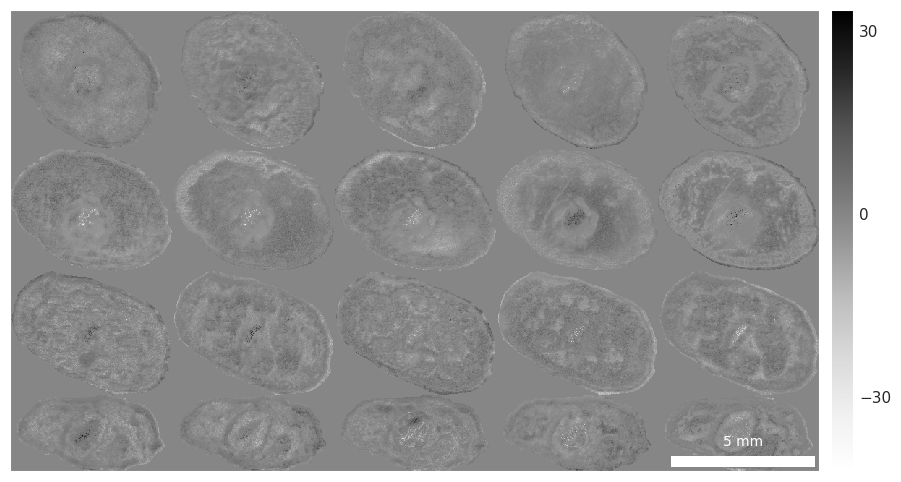

In [9]:
import seaborn_image as seaim
height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_dim

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_dim):
        
        rescaled = np.copy(ims_temp[k])
        mask = rescaled!=0
        # rescaled[mask] = rescaled[mask] - np.mean(rescaled[mask])
        # rescaled[mask] = rescaled[mask] / np.std(rescaled[mask])
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

# im_final[im_final!=0] = im_final[im_final!=0] - np.min(im_final)
# im_final[im_final!=0] = im_final[im_final!=0] / np.max(im_final)


seaim.imshow(im_final, cmap="Greys", dx=25, units="um")
plt.savefig("IV_A.png", dpi=350)
